# A First look at Simulations

## Introduction

CMB-ML manages a complex pipeline that processes data across multiple stages. Each stage produces outputs that need to be tracked, reused, and processed in later stages. Without a clear framework, this can lead to disorganized code, redundant logic, and errors.

The CMB-ML library offers a set of tools to manage the pipeline in a modular and scalable way.

Now that your local system is set up, we can examine some of the dataset instances. This notebook will load and show a configuration. It will use that configuration to download a set of simulation files and show them in two ways. Next it will do the same for a higher resolution, then show a comparison.

## Contents
View this notebook with [nbviewer](https://nbviewer.org/github/CMB-ML/cmb-ml/tree/main/demonstrations/D_first_look_at_sims.ipynb#Introduction) (or in your IDE) to enable these links.

- [Configuration](#Configuration)
- [Downloading a simulation](#Downloading-a-simulation)
- [Viewing a simulation](#Viewing-a-simulation)
- [Power spectra](#Power-spectra)
- [Higher resolution](#Higher-resolution)
- [Comparing resolutions](#Comparing-resolutions)
- [Conclusion](#Conclusion)

## Set-up

We need to set up the environment, importing hydra and providing the location of your local system configuration.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np

import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

# Set the location of the data directory
os.environ["CMB_ML_DATA"] = "/data/jim/CMB_Data"

# Configuration

Two datasets are provided: a low-resolution $\text{N}_\text{side}=128$ and a higher resolution $\text{N}_\text{side}=512$ dataset. It's faster and easier to work with the lower resolution dataset, so we'll use that for the first few examples here. We'll use the higher resolution dataset at the end as well.

In [3]:
json_128_fn = "upload_records_CMB-ML_128_1450.json"
json_512_fn = "upload_records_CMB-ML_512_1450.json"

First, we'll set up the configuration by loading it from a config file. You can find this configuration file at [cfg/config_demoD_dataset.yaml](../cfg/config_demoD_dataset.yaml)

In [4]:
hydra.core.global_hydra.GlobalHydra.instance().clear() # if re-initialize is needed, clear the global hydra instance (in case of multiple calls to initialize)

initialize(version_base=None, config_path="./cfg")

cfg = compose(config_name='config_demoD_dataset.yaml',
              overrides=['nside=128', 'map_fields="I"'])

We examine the configuration as loaded in the next cell. Compare it to the file itself:
- Defaults have been filled in 
    - e.g., the value for `file_system` is not the filename "common_fs", it is the contents of [cfg/file_system/common_fs.yaml](../cfg/file_system/common_fs.yaml)
- Interpolation is performed 
    - e.g., the `dataset_name` is not "\${scenario.map_fields}\_${scenario.nside}\_${splits.name}", it is "I_128_1450"

In [5]:
print(OmegaConf.to_yaml(cfg, resolve=True))

local_system:
  datasets_root: /data/jim/CMB_Data/Datasets/
  assets_dir: /data/jim/CMB_Data/Assets/
file_system:
  sim_folder_prefix: sim
  sim_str_num_digits: 4
  dataset_template_str: '{root}/{dataset}/'
  default_dataset_template_str: '{root}/{dataset}/{stage}/{split}/{sim}'
  working_dataset_template_str: '{root}/{dataset}/{working}{stage}/{split}/{sim}'
  subdir_for_log_scripts: scripts
  log_dataset_template_str: '{root}/{dataset}/{hydra_run_dir}'
  log_stage_template_str: '{root}/{dataset}/{working}{stage}/{hydra_run_dir}'
  top_level_work_template_str: '{root}/{dataset}/{stage}/{hydra_run_dir}'
  wmap_chains_dir: WMAP/wmap_lcdm_mnu_wmap9_chains_v5
scenario:
  nside: 128
  detector_freqs:
  - 30
  - 44
  - 70
  - 100
  - 143
  - 217
  - 353
  - 545
  - 857
  map_fields: I
  precision: float
  units: uK_CMB
  full_instrument:
    30: IQU
    44: IQU
    70: IQU
    100: IQU
    143: IQU
    217: IQU
    353: IQU
    545: I
    857: I
splits:
  name: '1450'
  Train:
    n_sims: 1

(In case there are issues) Results should look like:

```
local_system:
  datasets_root: /data/jim/CMB_Data/Datasets/
  assets_dir: /data/jim/CMB_Data/Assets/
file_system:
  sim_folder_prefix: sim
  sim_str_num_digits: 4
  dataset_template_str: '{root}/{dataset}/'
  default_dataset_template_str: '{root}/{dataset}/{stage}/{split}/{sim}'
  working_dataset_template_str: '{root}/{dataset}/{working}{stage}/{split}/{sim}'
  subdir_for_log_scripts: scripts
  log_dataset_template_str: '{root}/{dataset}/{hydra_run_dir}'
  log_stage_template_str: '{root}/{dataset}/{working}{stage}/{hydra_run_dir}'
  top_level_work_template_str: '{root}/{dataset}/{stage}/{hydra_run_dir}'
  wmap_chains_dir: WMAP/wmap_lcdm_mnu_wmap9_chains_v5
scenario:
  nside: 128
  detector_freqs:
  - 30
  - 44
  - 70
  - 100
  - 143
  - 217
  - 353
  - 545
  - 857
  map_fields: I
  precision: float
  units: K_CMB
  full_instrument:
    30: IQU
    44: IQU
    70: IQU
    100: IQU
    143: IQU
    217: IQU
    353: IQU
    545: I
    857: I
splits:
  name: '1450'
  Train:
    n_sims: 200
  Valid:
    n_sims: 250
  Test:
    n_sims: 200
dataset_name: I_128_1450
working_dir: Simulation_Working/
nside: 128
detectors:
- 30
- 44
- 70
- 100
- 143
- 217
- 353
- 545
- 857
map_fields: I
```

We'll use the first data instance, simulation 0 from the Train split.

In [6]:
split = "Train"
sim_num = 0

# Downloading a simulation

In the following cell, a helper module which will manage details of the CMB-ML pipeline framework. The imported function will use the configuration file to get the proper simulation and to download it to the expected location in the dataset. It will re-download the same simulation maps if you've already gotten them.

In [7]:
from helpers.get_dataset_helper import get_simulation

dest = get_simulation(cfg, json_128_fn, split, sim_num)  # 10s including download of 15 MB file

In [8]:
if dest.exists():
    print(f"Simulation acquired to {dest}")

Simulation acquired to /data/jim/CMB_Data/Datasets/I_128_1450/Simulation/Train/sim0000


That downloaded the simulation (stored as a `.tar.gz`) and extracted it. In your dataset folder, assuming nothing was there before, you will have:
```
└─ Datasets
   └─ I_128_1450
      ├─ Simulation
      |    └─ Train
      |         └─ sim0000
      |              ├─ cmb_map_fid.fits
      |              ├─ obs_30_map.fits
      |              ├─ obs_44_map.fits
      |              ├─ obs_70_map.fits
      |              ├─ obs_100_map.fits
      |              ├─ obs_143_map.fits
      |              ├─ obs_217_map.fits
      |              ├─ obs_353_map.fits
      |              ├─ obs_545_map.fits
      |              └─ obs_857_map.fits
      └─ Simulation_Working
           ├─ Simulation_C_Configs
           |    └─ Train
           |         └─ sim0000
           |              └─ wmap_params.yaml
           └─ Simulation_CMB_Power_Spectra
                └─ Train
                     └─ sim0000
                          └─ cmb_ps_fid.txt
```
The eleven files listed are the ones we consider most likely to be the ones wanted for CMB-ML purposes. Please contact us if you need the noise files generated. We have an archive of them, but they make the dataset considerably larger.

# Viewing a simulation

There's a couple ways we can look at the acquired data. Let's first see the most intuitive form: sky maps. We have maps for both CMB and the observations; we'll demonstrate utilities for looking at both.

First, the CMB.

In [9]:
import healpy as hp
from cmbml.core.asset_handlers.healpy_map_handler import HealpyMap

In [10]:
map_handler = HealpyMap()
# _fid is for "fiducial" map; the authors have since adopted the use of the term "realization" instead.
#   This is an unfortunate relic that we hope to fix.
cmb_map_path = dest / "cmb_map_fid.fits"

The map handler returns a numpy array with shape $\text{N}_\text{fields} \times \text{N}_\text{side}$. Map fields refers to having either only temperature (I) or temperature and polarization data (IQU), so $\text{N}_\text{fields}$ is either 1 or 3. We're just going to consider temperature fields. Current simulations do not include polarization.

In [11]:
cmb_map = map_handler.read(cmb_map_path)
cmb_T_map_128 = cmb_map[0]  # [0] to specify the Temperature (Intensity, "I") map

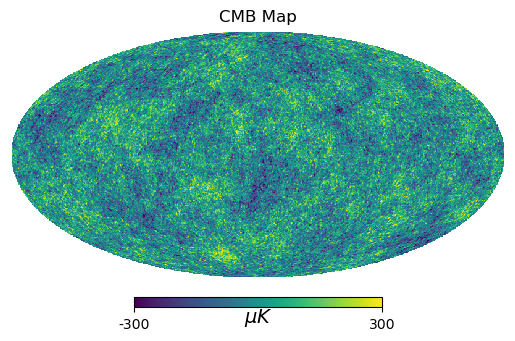

In [12]:
hp.mollview(cmb_T_map_128, 
            title="CMB Map", 
            cbar=True,       # Show the colorbar
            unit="$\mu K$",  # Display microKelvin units
            min=-300,        # Set the minimum value of the colorbar
            max=300,         # Set the maximum value of the colorbar
            hold=True        # Typically for displaying multiple plots, 
                             # hold=True also resizes the figure for a smaller notebook
            )

Let's look at the 100 GHz observation first. Note that we change the colorscale to enable comparison across different detection frequencies.

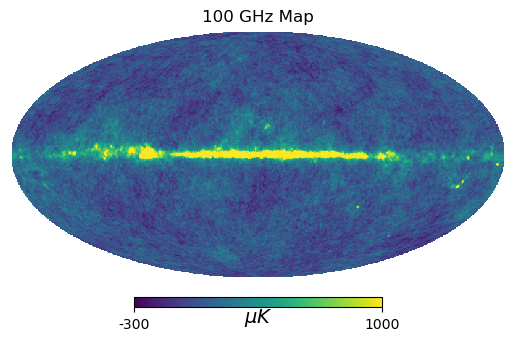

In [13]:
map_100GHz_path = dest / "obs_100_map.fits"
map_100GHz = map_handler.read(map_100GHz_path)[0]
hp.mollview(map_100GHz, title="100 GHz Map", cbar=True, unit="$\mu K$", min=-300, max=1000, hold=True)

We still see a lot of the CMB signal showing through. Observations at other frequencies have more dominant foreground signal.

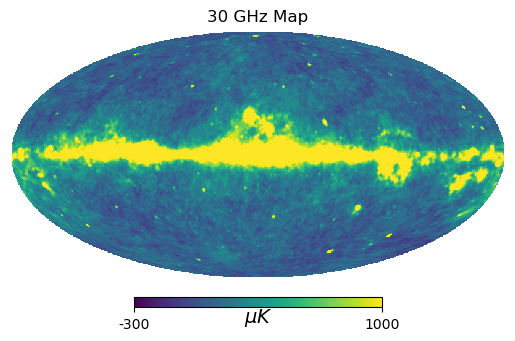

In [14]:
map_30GHz_path = dest / "obs_30_map.fits"
map_30GHz = map_handler.read(map_30GHz_path)[0]
hp.mollview(map_30GHz, title="30 GHz Map", cbar=True, unit="$\mu K$", min=-300, max=1000, hold=True)

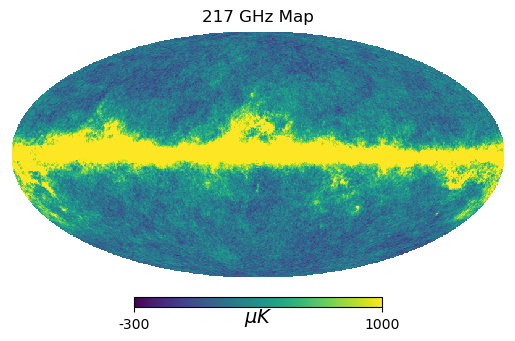

In [15]:
map_217GHz_path = dest / "obs_217_map.fits"
map_217GHz = map_handler.read(map_217GHz_path)[0]
hp.mollview(map_217GHz, title="217 GHz Map", cbar=True, unit="$\mu K$", min=-300, max=1000, hold=True)

Note that the scale bars have had to change to accomodate the different intensity of these contaminants.

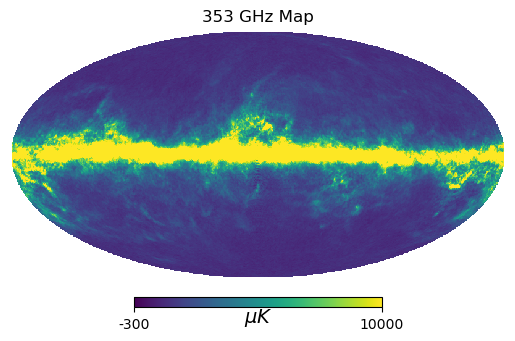

In [16]:
map_353GHz_path = dest / "obs_353_map.fits"
map_353GHz = map_handler.read(map_353GHz_path)[0]
hp.mollview(map_353GHz, title="353 GHz Map", cbar=True, unit="$\mu K$", min=-300, max=10000, hold=True)

The impact of these foregrounds is described in a chart from the Planck Collaboration's 2015 X publication<sup id="a1">[1](#f1)</sup>, in Figure 51, reproduced here:

![Foreground contaminant signal strength](assets/readme_imgs/SEDs.png)

We can see the CMB most clearly at the central frequencies (100 and 217 GHz), while foregrounds are more apparent at the high (353 GHz) and low (30 GHz) frequencies.

# Power spectra

The map information is also commonly viewed in the spherical harmonics domain, as power spectra.

In [17]:
from cmbml.utils.physics_ps import get_auto_ps_result

We get the power spectrum as a PowerSpectrum object. There is some ambiguity involved with power spectra and the way they've been processed. This object helps keep things straight.

In this case, we want the "deconvolved" and "scaled" spectrum. We know the map is ground truth, and so there's no convolution to simulate instrumentation effects. We're also plotting the $\text{D}_\ell$, where $\text{D}_\ell = \frac{\ell(\ell+1)}{2\pi} \text{C}_\ell$ is a scaled form which is easier to view. Thus, we use the `.deconv_dl` property of the object.

<a id="128_power_spectra_calc"></a>

In [18]:
cmb_ps_128 = get_auto_ps_result(cmb_T_map_128,
                                lmax=3*cfg.nside    # The resolution of the map is a bandwidth limit of the signal. The lmax is a representation of that.
                                                    # The typical value is 3 * N_side
                                )
# We want the Deconvolved Dl, as explained in the above markdown cell.
cmb_ps_128 = cmb_ps_128.deconv_dl

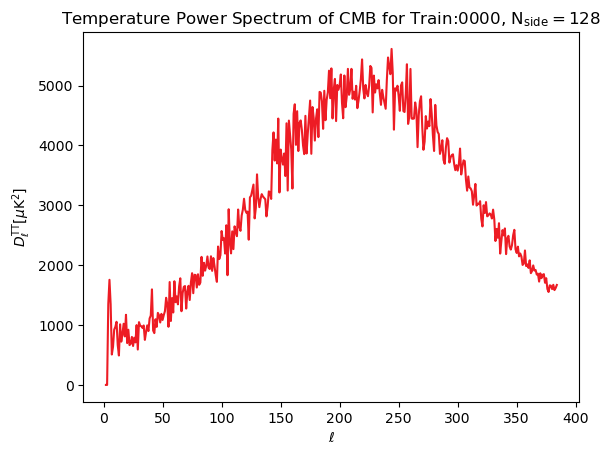

In [19]:
plot_params = dict(color="#ED1C24", label='Realization')

ylabel_rel = '$\\%\\Delta D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$'
ells_128 = np.arange(cmb_ps_128.shape[0])

cmb_ps_128 = cmb_ps_128[2:]
ells_128 = ells_128 [2:]

plt.plot(ells_128, cmb_ps_128, **plot_params)
plt.ylabel('$D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$')
plt.title(f'Temperature Power Spectrum of CMB for {split}:{sim_num:04d}, N$_' + '\\mathrm{side}=128$')
plt.xlabel('$\\ell$');

It may not look exactly like what you expect (from Planck's official results<sup id="a2">[2](#f2)</sup>):

![Planck's official power spectrum](assets/readme_imgs/Planck_Power_Spectrum_pillars.jpg)

There are a few reasons for this. The first of these is scale. We've used a smaller asset ($\text{N}_\text{side}=128$) for demonstration, which only contains meaningful information up to roughly $3 \times \textrm{N}_\textrm{side} = 384$, though accuracy decreases above $2\times \textrm{N}_\textrm{side}$.

The second, causing the jaggedness, is that this map is a realization (random instantiation) of the CMB map from the ground truth theory power spectrum. There's much more to discuss on the implications of how to properly compare model performance in light of this.

Also note that in the image above, the top axis is labelled $\ell$, and the horizontal axis is split, using logarithmic scaling below $\ell=30$.

# Higher resolution

For comparison, we load and show an instance from the main dataset, IQU-512-1450. Each instance for this dataset is 230 MB, as compared to the 15 MB for the I-128-1450 dataset.

The following cell gets the simulation.

In [21]:
hydra.core.global_hydra.GlobalHydra.instance().clear() # Re-initialize is needed

initialize(version_base=None, config_path="cfg")

cfg = compose(config_name='config_demoD_dataset.yaml',
              overrides=['nside=512', 'map_fields="I"'])

dest = get_simulation(cfg, json_512_fn, split, sim_num)  # 14s including download of 230 MB file

The map does not look much different; the differences are at finer scales.

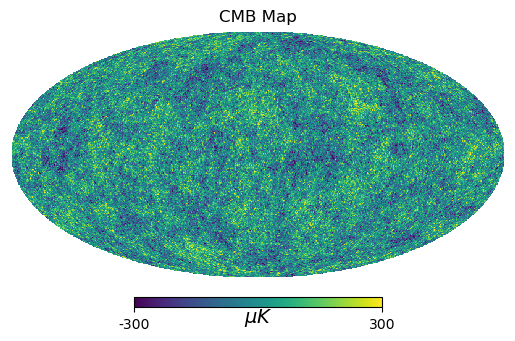

In [22]:
map_handler = HealpyMap()
cmb_map = map_handler.read(dest / "cmb_map_fid.fits")
cmb_T_map_512 = cmb_map[0]  # [0] to get the Temperature (Intensity) map
hp.mollview(cmb_T_map_512, title="CMB Map", cbar=True, unit="$\mu K$", min=-300, max=300, hold=True)

We can again get the power spectrum for this map. Because $\textrm{N}_\textrm{side}=512$, we can go to higher $\ell_\mathit{max}$.

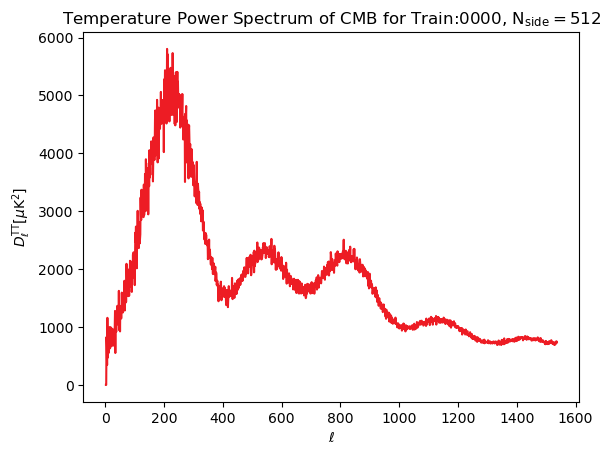

In [23]:
cmb_ps_512 = get_auto_ps_result(cmb_T_map_512,
                                lmax=3*cfg.nside)

cmb_ps_512 = cmb_ps_512.deconv_dl

plot_params = dict(color="#ED1C24", label='Realization')
ylabel_rel = '$\\%\\Delta D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$'
ells_512 = np.arange(cmb_ps_512.shape[0])

cmb_ps_512 = cmb_ps_512[2:]
ells_512 = ells_512 [2:]

plt.plot(ells_512, cmb_ps_512, **plot_params)
plt.ylabel('$D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$')
plt.title(f'Temperature Power Spectrum of CMB for {split}:{sim_num:04d}, N$_' + '\\mathrm{side}=512$')
plt.xlabel('$\\ell$');

There are issues with this power spectrum: we do not account for beam or pixel windows. Nevertheless, it is a reasonable early check.

# Comparing resolutions

By looking more closely at the maps, we can see differences. Instead of making very large Molleweide projections, we instead use a Gnomonic projection, which flattens the map.

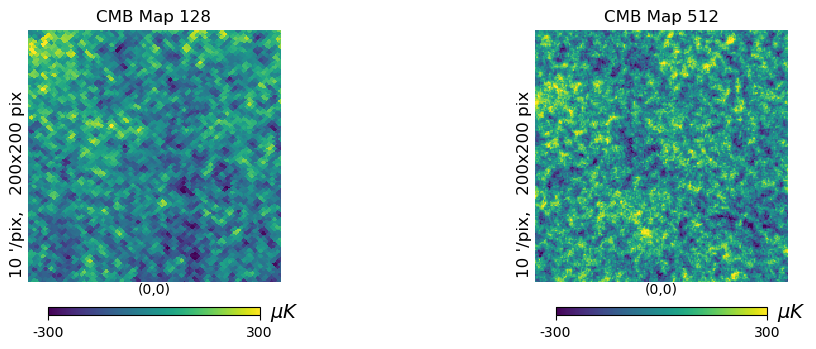

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

plt.axes(ax0)
hp.gnomview(cmb_T_map_128, title="CMB Map 128", reso=10, cbar=True, unit="$\mu K$", min=-300, max=300, hold=True)
plt.axes(ax1)
hp.gnomview(cmb_T_map_512, title="CMB Map 512", reso=10, cbar=True, unit="$\mu K$", min=-300, max=300, hold=True)

Note that the $\textrm{N}_\textrm{side}=128$ map on the left is more granular than the $\textrm{N}_\textrm{side}=512$ map. The CMB pattern is also different because it is a different random instantiation.

In [25]:
def plot_ps_given_lmax(lmax=384):
    cmb_ps_128 = get_auto_ps_result(cmb_T_map_128,
                                    lmax=lmax)
    cmb_ps_128 = cmb_ps_128.deconv_dl

    cmb_ps_512 = get_auto_ps_result(cmb_T_map_512,
                                    lmax=lmax)
    cmb_ps_512 = cmb_ps_512.deconv_dl

    plot_params_128 = dict(color="tab:blue", label='$\\mathrm{N}_\\mathrm{side}=128$')
    plot_params_512 = dict(color="tab:red", label='$\\mathrm{N}_\\mathrm{side}=512$')
    ylabel_rel = '$\\%\\Delta D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$'
    ells = np.arange(cmb_ps_512.shape[0])

    cmb_ps_128 = cmb_ps_128[2:]
    cmb_ps_512 = cmb_ps_512[2:]
    ells = ells[2:]

    plt.plot(ells, cmb_ps_128, **plot_params_128)
    plt.plot(ells, cmb_ps_512, **plot_params_512)
    plt.ylabel('$D_{\ell}^\\text{TT} [\\mu \\text{K}^2]$')
    plt.ylim(0, 8e3)
    plt.title('Temperature Power Spectrum of CMB at different $\\mathrm{N}_\\mathrm{side}$')
    plt.legend()
    plt.xlabel('$\\ell$');

The power spectra are almost the same, when calculated with $\ell_\mathit{max}=384 \quad (= 3 \times 128$)

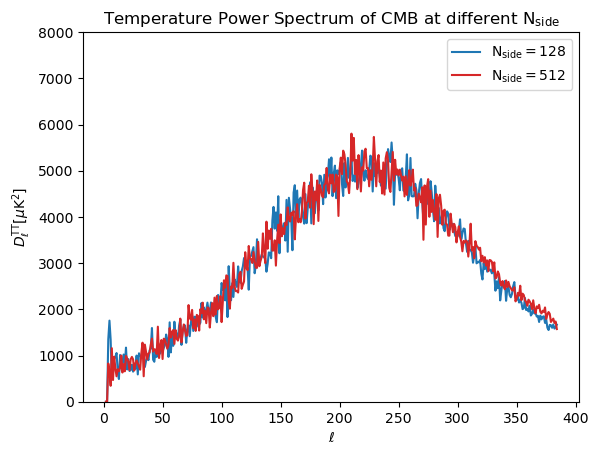

In [26]:
plot_ps_given_lmax(384)

But, given higher $\ell_\mathit{max}=512$, we see issues emerge.

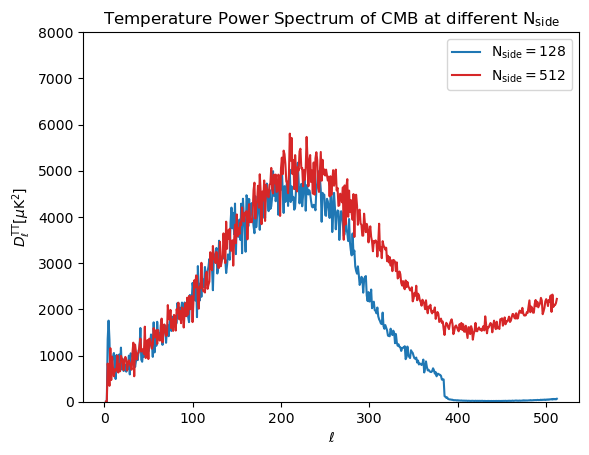

In [27]:
plot_ps_given_lmax(512)

The difference between the spectra is because the spherical harmonic transformation is being performed outside of the region appropriate for a low resolution map; recommendations are described in the [ANAFAST documentation](https://healpix.sourceforge.io/html/fac_anafast.htm). There are many caveats and considerations when producing power spectra; this has been a greatly reduced introduction.

Changing to higher $\ell_\textit{max}$ will result in both stern repetitive warnings and garbage output for the $\mathrm{N}_\mathrm{side}=128$ map.

Despite these issues, the 128 maps are very useful for fast debugging.

# Conclusion

We've downloaded data and gotten a small preview of how to look at it.
- Configuration files were explored in more detail.
- A simulation at $\mathrm{N}_\mathrm{side}=128$ was downloaded and the file structure was described.
- Maps of the CMB ground truth and observations were rendered using Healpy.
- An oversimplified power spectrum was calculated.
- A higher resolution ($\mathrm{N}_\mathrm{side}=512) simulation was downloaded and looked at.
- The resolutions were compared.

From here, there are a few options for next steps:
- [Get the dataset](./C_setting_up_local.ipynb#Getting-the-dataset) (as described in the previous notebook)
- Continue through the demonstrations.
    - [The CMB-ML framework code](./E_CMB_ML_framework.ipynb)
    - [The CMB-ML pipeline code](./F_CMB_ML_pipeline.ipynb)
    - [CMB-ML executors](./G_CMB_ML_executors.ipynb)
- Or run any of the top-level scripts. 

Diving in may be the best bet, returning to the demonstrations as you need.

<!-- More in-depth looks at using models and analysis code can be found in the `paper_figures/` directory:
- [dataset_results.ipynb](../paper_figures/dataset_results.ipynb): Plotting maps after cleaning
- [make_component_maps.ipynb](../paper_figures/make_component_maps.ipynb): Creates single-component maps, for use in other analysis (next line)
- [paper_components.ipynb](../paper_figures/paper_components.ipynb): Creates figures showing single components (requires previous line having been run)
- [paper_figure_planck_obs_and_target.ipynb](../paper_figures/paper_figure_planck_obs_and_target.ipynb): Creates figures of Planck's observation maps and predicted CMB
- [paper_figure_planck_variance.ipynb](../paper_figures/paper_figure_planck_variance.ipynb): Creates the figure of Planck's variance map at 100 GHz
- [planck_fwhm_detail.ipynb](../paper_figures/planck_fwhm_detail.ipynb): Creates figures with the detail view of Plancks's maps, such that the effect of different FWHMs is visible -->


## References

<p id="f1"><sup><a href="#a1">1</a></sup> R. Adam, P. A. Ade, N. Aghanim, M. Alves, M. Arnaud, M. Ashdown, J. Aumont, C. Baccigalupi, A. Banday, R. Barreiro, et al. Planck 2015 Results-X. Diffuse Component Separation Foreground Maps. Astronomy & Astrophysics, 594:A10, 2016

<p id="f2"><sup><a href="#a2">2</a></sup> <a href="https://www.esa.int/ESA_Multimedia/Images/2013/03/Planck_Power_Spectrum">https://www.esa.int/ESA_Multimedia/Images/2013/03/Planck_Power_Spectrum</a>